# Topic Modeling
Based on: Social Media Analytics – Introduction to Text Mining – Topic Modeling

by (c) Nuno Antonio 2019-2021 Version 1.10

### Initial setup

In [1]:
# Import packages
import csv
import pandas as pd
import numpy as np
import nltk 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import gensim         
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
#import pyLDAvis.gensim

# For pyLDAvis new version - replace the previous line
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


import matplotlib.pyplot as plt

from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import emoji

In [2]:
# Just because of versions on my computer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Load dataset
base_path = "Data/"
ds = pd.read_excel(base_path + "Tweets_cleaned.xlsx")

### Functions

In [4]:
# Replace emojis and smileys

# Converting emojis to words
# Using both emot and emoji package to cover missing emojis
def convert_emojis(text):
    # from https://towardsdatascience.com/text-preprocessing-for-data-scientist-3d2419c8199d
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))

    emoji.demojize(text, delimiters=("", "")) 
    return text
# Converting emoticons to words   
# from https://towardsdatascience.com/text-preprocessing-for-data-scientist-3d2419c8199d 
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

def remove_emoji(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "")
    return text

def remove_emoticon(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "", text)
    return text



In [5]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True, convert_emojis=False, remove_emojis = False):
    cleanedText = []
    for x in (rawText[:]): 
        
        if type(x) != str:
            print("Type: ", str(type(x)))
            x = str(x)
        
        # Remove HTML
        if removeHTML:
            procText = BeautifulSoup(x,'html.parser').get_text()

        if convert_emojis:
            procText = convert_emojis(procText)
            procText = convert_emoticons(procText)
        
        if remove_emojis:
            procText = remove_emoji(procText)
            procText = remove_emoticon(procText)

         # Remove punctuation and other special characters
        if len(charsToRemove)>0:
            procText = re.sub(charsToRemove,' ',procText)

        # Remove numbers
        if removeNumbers:
            procText = re.sub(r'\d+',' ',procText)

        # Remove line breaks
        if removeLineBreaks:
            procText = procText.replace('\n',' ').replace('\r', '')

        # Remove special characters
        if len(specialCharsToRemove)>0:
            procText = re.sub(specialCharsToRemove,' ',procText)

        # Normalize to lower case
        if convertToLower:
            procText = procText.lower() 

        # Replace multiple consecutive spaces with just one space
        if removeConsecutiveSpaces:
            procText = re.sub(' +', ' ', procText)


        cleanedText.append(procText)


    return cleanedText

In [6]:
# Tokenize texts
def tokenize_words(texts):
    words_new = []
    for w in (texts[:]):
        w_token = word_tokenize(w)
        if w_token != '':
            words_new.append(w_token)
    return words_new

In [7]:
# Function to recreate text from words
def recreateText(words):
    text_new = []
    for w in (words[:]):
        temp_str = (' ').join(w)
        text_new.append(temp_str)
    return text_new

In [8]:
# Function to remove stop words
def removeStopWords(texts, stop_words):
  procText = []
  for t in (texts[:]):
    cleaned_text = [w for w in t[:] if not w in stop_words]
    procText.append(cleaned_text)
  return procText

In [9]:
# Function to lemmatize words
def lemmatize(words):
  lemmatizer = WordNetLemmatizer()
  procText = []
  for w in (words[:]):
    lemmatized_word = [lemmatizer.lemmatize(x) for x in (w[:])]
    procText.append(lemmatized_word)
  return procText

### Analysis

In [10]:
# Preprocess text 
processedTweets =  pd.DataFrame(data=textPreProcess(ds.text, removeLineBreaks=True, removeNumbers=True, convertToLower=True, convert_emojis=False, remove_emojis=True), columns=['PreProcessedText']) 

Type:  <class 'int'>


In [21]:
# Tokekinze words
processedTweets['Words'] =  tokenize_words(processedTweets['PreProcessedText'])

# Remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(["vaccine", "vaccination", "vax", "covid", "vaccinated"])
processedTweets['WordsCleaned'] = removeStopWords(processedTweets['Words'], stop_words)

# Lemmative words
processedTweets['WordsLemmatized'] = lemmatize(processedTweets['WordsCleaned'])

In [22]:
processedTweets

,PreProcessedText,Words,WordsCleaned,WordsLemmatized
0,doesn't vaccine approval typically take and mo...,"[does, n't, vaccine, approval, typically, take...","[n't, approval, typically, take, months, askin...","[n't, approval, typically, take, month, asking..."
1,you're right too bad this vaccine doesn't have...,"[you, 're, right, too, bad, this, vaccine, doe...","['re, right, bad, n't, decades, research, dont...","['re, right, bad, n't, decade, research, dont,..."
2,the vaccine is free,"[the, vaccine, is, free]",[free],[free]
3,the world needs vaccine access now the must s...,"[the, world, needs, vaccine, access, now, the,...","[world, needs, access, must, step, sharing, bi...","[world, need, access, must, step, sharing, bil..."
4,but you can get it i remember getting my mumps...,"[but, you, can, get, it, i, remember, getting,...","[get, remember, getting, mumps, never, got, mu...","[get, remember, getting, mumps, never, got, mu..."
...,...,...,...,...
22529,the country need to check on people who take o...,"[the, country, need, to, check, on, people, wh...","[country, need, check, people, take, masks, wi...","[country, need, check, people, take, mask, wit..."
22530,why can you not go maskless with out vaccine y...,"[why, can, you, not, go, maskless, with, out, ...","[go, maskless, still, catch/transmit, mask]","[go, maskless, still, catch/transmit, mask]"
22531,you say the immunocomprimised should discuss t...,"[you, say, the, immunocomprimised, should, dis...","[say, immunocomprimised, discuss, need, person...","[say, immunocomprimised, discus, need, persona..."
22532,well kate not everyone is vaccinated and the v...,"[well, kate, not, everyone, is, vaccinated, an...","[well, kate, everyone, %, effective, perhaps, ...","[well, kate, everyone, %, effective, perhaps, ..."


In [23]:
# Create dictionary (needed for LDA)
id2word = corpora.Dictionary(processedTweets['WordsLemmatized'])

In [24]:
# Create corpus
corpus = processedTweets['WordsLemmatized']

In [25]:
# Create TDM (Frequency)
tdm = [id2word.doc2bow(text) for text in corpus]

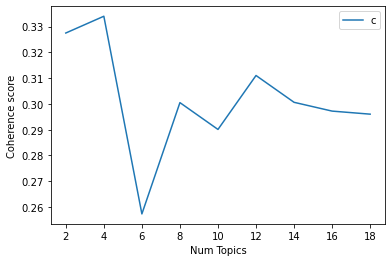

In [30]:
# Determine the optimal number of topics according to the coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# ATTENTION!!!! Can take a LONG time to run.
lowerBound = 2
upperBound = 20
step = 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tdm, texts=corpus, start=lowerBound, limit=upperBound, step= step)

# Show graph
x = range(lowerBound, upperBound, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**There is a peak before a decrease at 12 topics, therefore we choose the number.**

In [33]:
# Build LDA model with 12 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=tdm,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto')

In [34]:
data = processedTweets['WordsLemmatized']

In [35]:
# Print the keywords in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[tdm]
# Interpretation: Topic 0 is represented as 0.055"walking" + 0.054"garden" + ...

[(0, '0.062*"got" + 0.055*"shot" + 0.050*"blood" + 0.049*"clot" + 0.038*"dying" + 0.038*"science" + 0.030*"told" + 0.028*"put" + 0.027*"effective" + 0.026*"variant"'), (1, '0.067*"u" + 0.044*"j" + 0.035*"%" + 0.033*"would" + 0.031*"like" + 0.029*"vaccine" + 0.025*"cdc" + 0.024*"make" + 0.022*"also" + 0.019*"stop"'), (2, '0.287*"need" + 0.115*"immune" + 0.061*"live" + 0.051*"doctor" + 0.039*"must" + 0.033*"infected" + 0.028*"herd" + 0.026*"republican" + 0.025*"access" + 0.016*"compromised"'), (3, '0.135*"n\'t" + 0.094*"\'s" + 0.047*"virus" + 0.030*"\'m" + 0.029*"died" + 0.028*"use" + 0.023*"american" + 0.020*"ca" + 0.018*"never" + 0.013*"enough"'), (4, '0.099*"people" + 0.095*"get" + 0.034*"want" + 0.029*"getting" + 0.029*"take" + 0.024*"know" + 0.018*"say" + 0.018*"many" + 0.017*"right" + 0.015*"time"'), (5, '0.050*"risk" + 0.049*"country" + 0.042*"please" + 0.040*"life" + 0.038*"help" + 0.037*"world" + 0.033*"may" + 0.028*"health" + 0.025*"dos" + 0.025*"around"'), (6, '0.131*"mask" + 

In [36]:
# Visualize the topics 
vis = gensimvis.prepare(lda_model, tdm, id2word)
pyLDAvis.display(vis)


In [37]:
# Find dominant topic for each Tweet
# from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Function
    
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=tdm, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1927,"u, j, %, would, like, vaccine, cdc, make, also...","[n't, approval, typically, take, month, asking..."
1,1,4.0,0.3751,"people, get, want, getting, take, know, say, m...","['re, right, bad, n't, decade, research, dont,..."
2,2,4.0,0.1837,"people, get, want, getting, take, know, say, m...",[free]
3,3,2.0,0.2722,"need, immune, live, doctor, must, infected, he...","[world, need, access, must, step, sharing, bil..."
4,4,0.0,0.1990,"got, shot, blood, clot, dying, science, told, ...","[get, remember, getting, mumps, never, got, mu..."
5,5,3.0,0.2760,"n't, 's, virus, 'm, died, use, american, ca, n...","[self, preservation, duh, understand, virus, p..."
6,6,9.0,0.2920,"one, citizen, week, passport, harris, proof, g...","[yep, 's, nearly, even, close, bad, medium, ma..."
7,7,4.0,0.2428,"people, get, want, getting, take, know, say, m...","[maybe, clearing, student, debt, would, great,..."
8,8,4.0,0.3603,"people, get, want, getting, take, know, say, m...","[say, anything, wrong, action, said, basically..."
9,9,1.0,0.1997,"u, j, %, would, like, vaccine, cdc, make, also...","[lot, people, doubt, lot, people, also, feel, ..."


In [38]:
# Check the topic counts
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts

4.0     11351
1.0      6431
6.0      1771
3.0       824
2.0       781
5.0       653
9.0       226
8.0       211
0.0       116
11.0      109
7.0        54
10.0        7
Name: Dominant_Topic, dtype: int64

In [45]:
# Give label to each topic
one = "People get (vaccinated)"
two = "Death/Child"
three = "Mask"
four = "Death/Infection"
five = "Risk/Country/mRNA"
six = "Passport/Citizien"
seven = "Biden/Trump"
eight = "Fight/Plan"
nine = "Blood cloth/Research"
ten = "Experiment"
eleven = "Herd immunity/Republicans/Sharing"
twelve = "Administration/Effectivness"



In [46]:
# Build list of topic label according to the dominant topics
# Topic numbers start at 0
topics = []
for topic_num in df_dominant_topic["Dominant_Topic"]:
    if topic_num == 0:
        topics.append(one)
    elif topic_num == 1:
        topics.append(two)
    elif topic_num == 2:
        topics.append(three)
    elif topic_num == 3:
        topics.append(four)
    elif topic_num == 4:
        topics.append(five)
    elif topic_num == 5:
        topics.append(six)
    elif topic_num == 6:
        topics.append(seven)
    elif topic_num == 7:
        topics.append(eight)
    elif topic_num == 8:
        topics.append(nine)
    elif topic_num == 9:
        topics.append(ten)
    elif topic_num == 10:
        topics.append(eleven)
    elif topic_num == 11:
        topics.append(twelve)
    else:
        raise Exception("Num not found ", topic_num)

In [47]:
ds["Topic"]= topics

In [48]:
ds

,text,user screen name,user followers,url,created at,replies,retweets,likes,mention,hashtag,Topic
0,Doesn't vaccine approval typically take 6 and ...,spadesgeek,19,https://mobile.twitter.com,2021-06-10 19:24:26.999999,0,0,0,"MatthewDavidH,EricTopol,TheEconomist,US_FDA,la...",NaN,Death/Child
1,"You're right, too bad this vaccine doesn't hav...",selirodz,78,http://twitter.com/download/android,2021-06-10 19:24:26.000000,0,0,0,"DharkArk,JoeBiden",NaN,Risk/Country/mRNA
2,The vaccine is free…❤️,FlowerGirlBaker,1486,http://twitter.com/#!/download/ipad,2021-06-10 19:23:57.000000,0,0,0,"theredshift11,POTUS,studentsfordemo",NaN,Risk/Country/mRNA
3,. the world needs vaccine access now. Th...,DevizesGreens,150,https://mobile.twitter.com,2021-06-10 19:23:49.000000,0,0,0,"BorisJohnson,JustinTrudeau,POTUS,EUCouncil,Reg...","COVID19,G7,EndThePandemic,COVAX",Mask
4,But you can get it.\nI remember getting my Mum...,canfixstoopid,355,https://mobile.twitter.com,2021-06-10 19:23:42.000000,0,0,0,"SerendipityOr,Shockwave_Shaun,Ozymandiyaas,Joe...",NaN,People get (vaccinated)
...,...,...,...,...,...,...,...,...,...,...,...
22529,The country need to check on people who take o...,LSungoun,90,http://twitter.com/download/android,2021-05-16 04:11:06.000000,0,0,0,"POTUS,HillaryClinton,Jaemyung_Lee",NaN,Risk/Country/mRNA
22530,Why can you not go maskless with out vaccine? ...,bcgov115,38,http://twitter.com/download/iphone,2021-05-16 04:11:01.000000,0,0,0,POTUS,NaN,Biden/Trump
22531,"You say the immunocomprimised ""should discuss ...",dmdmdtweet,1,http://twitter.com/download/android,2021-05-16 04:08:22.999999,0,0,1,CDCgov,NaN,Risk/Country/mRNA
22532,"Well, Kate, not everyone is vaccinated and the...",TuffCrusherPlus,83,http://twitter.com/download/iphone,2021-05-16 04:08:03.000000,0,0,0,"50treeK8,OregonGovBrown,CDCgov",NaN,Death/Child


In [49]:
ds.to_excel(base_path + "Tweets_Topics.xlsx", index=False)